In [1]:
## imports

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %load_ext autoreload
# the "1" means: always reload modules marked with "%aimport"
# %autoreload 1

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
# import mplsvds
# import mpld3
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings

sns.set_context("poster", font_scale=1.3)


/Users/ben/miniconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
dfd = pd.read_csv("../data/redcard/crowdstorm_disaggregated.csv.gz", compression='gzip')
#renaming Alpha_3 to playerCountry
dfd = dfd.rename(columns={'Alpha_3':'playerCountry'})


## Data Structure

> The dataset is available as a list with 146,028 dyads of players and referees and includes details from players, details from referees and details regarding the interactions of player-referees. A summary of the variables of interest can be seen below. A detailed description of all variables included can be seen in the README file on the project website. -- https://docs.google.com/document/d/1uCF5wmbcL90qvrk_J27fWAvDcDNrO9o_APkicwRkOKc/edit


| Variable Name: | Variable Description: | 
| -- | -- | 
| playerShort | short player ID | 
| player | player name | 
| club | player club | 
| leagueCountry | country of player club (England, Germany, France, and Spain) | 
| height | player height (in cm) | 
| weight | player weight (in kg) | 
| position | player position | 
| games | number of games in the player-referee dyad | 
| goals | number of goals in the player-referee dyad | 
| yellowCards | number of yellow cards player received from the referee | 
| yellowReds | number of yellow-red cards player received from the referee | 
| redCards | number of red cards player received from the referee | 
| photoID | ID of player photo (if available) | 
| rater1 | skin rating of photo by rater 1 | 
| rater2 | skin rating of photo by rater 1 | 
| refNum | unique referee ID number (referee name removed for anonymizing purposes) | 
| refCountry | unique referee country ID number | 
| meanIAT | mean implicit bias score (using the race IAT) for referee country | 
| nIAT | sample size for race IAT in that particular country | 
| seIAT | standard error for mean estimate of race IAT   | 
| meanExp | mean explicit bias score (using a racial thermometer task) for referee country | 
| nExp | sample size for explicit bias in that particular country | 
| seExp |  standard error for mean estimate of explicit bias measure | 

In [3]:
dfd.head()


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3


In [4]:
dfd.shape


(426572, 32)

In [5]:
dfd.columns


Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'playerCountry', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skintone', 'allreds', 'allredsStrict',
       'refCount'],
      dtype='object')

In [6]:
## how many distinct players in the dataset?
players = dfd['playerShort'].unique()
len(players)


2053

In [7]:
## how many distinct refs in the dataset?
dfd['refNum'].nunique()


3147

In [8]:
## what's the distribution of skin tone among players?
player_df = dfd[['playerShort', 'rater1', 'rater2', 'skintone']].drop_duplicates()


In [9]:
# sanity check: there should be 2,053 rows in player_df
assert player_df.shape[0] == 2053, "Error: player_df is not unique by player."


In [35]:
player_df.head()

,playerShort,rater1,rater2,skintone
0,lucas-wilchez,0.25,0.50,0.375
1,john-utaka,0.75,0.75,0.750
2,abdon-prats,NaN,NaN,NaN
3,pablo-mari,NaN,NaN,NaN
4,ruben-pena,NaN,NaN,NaN


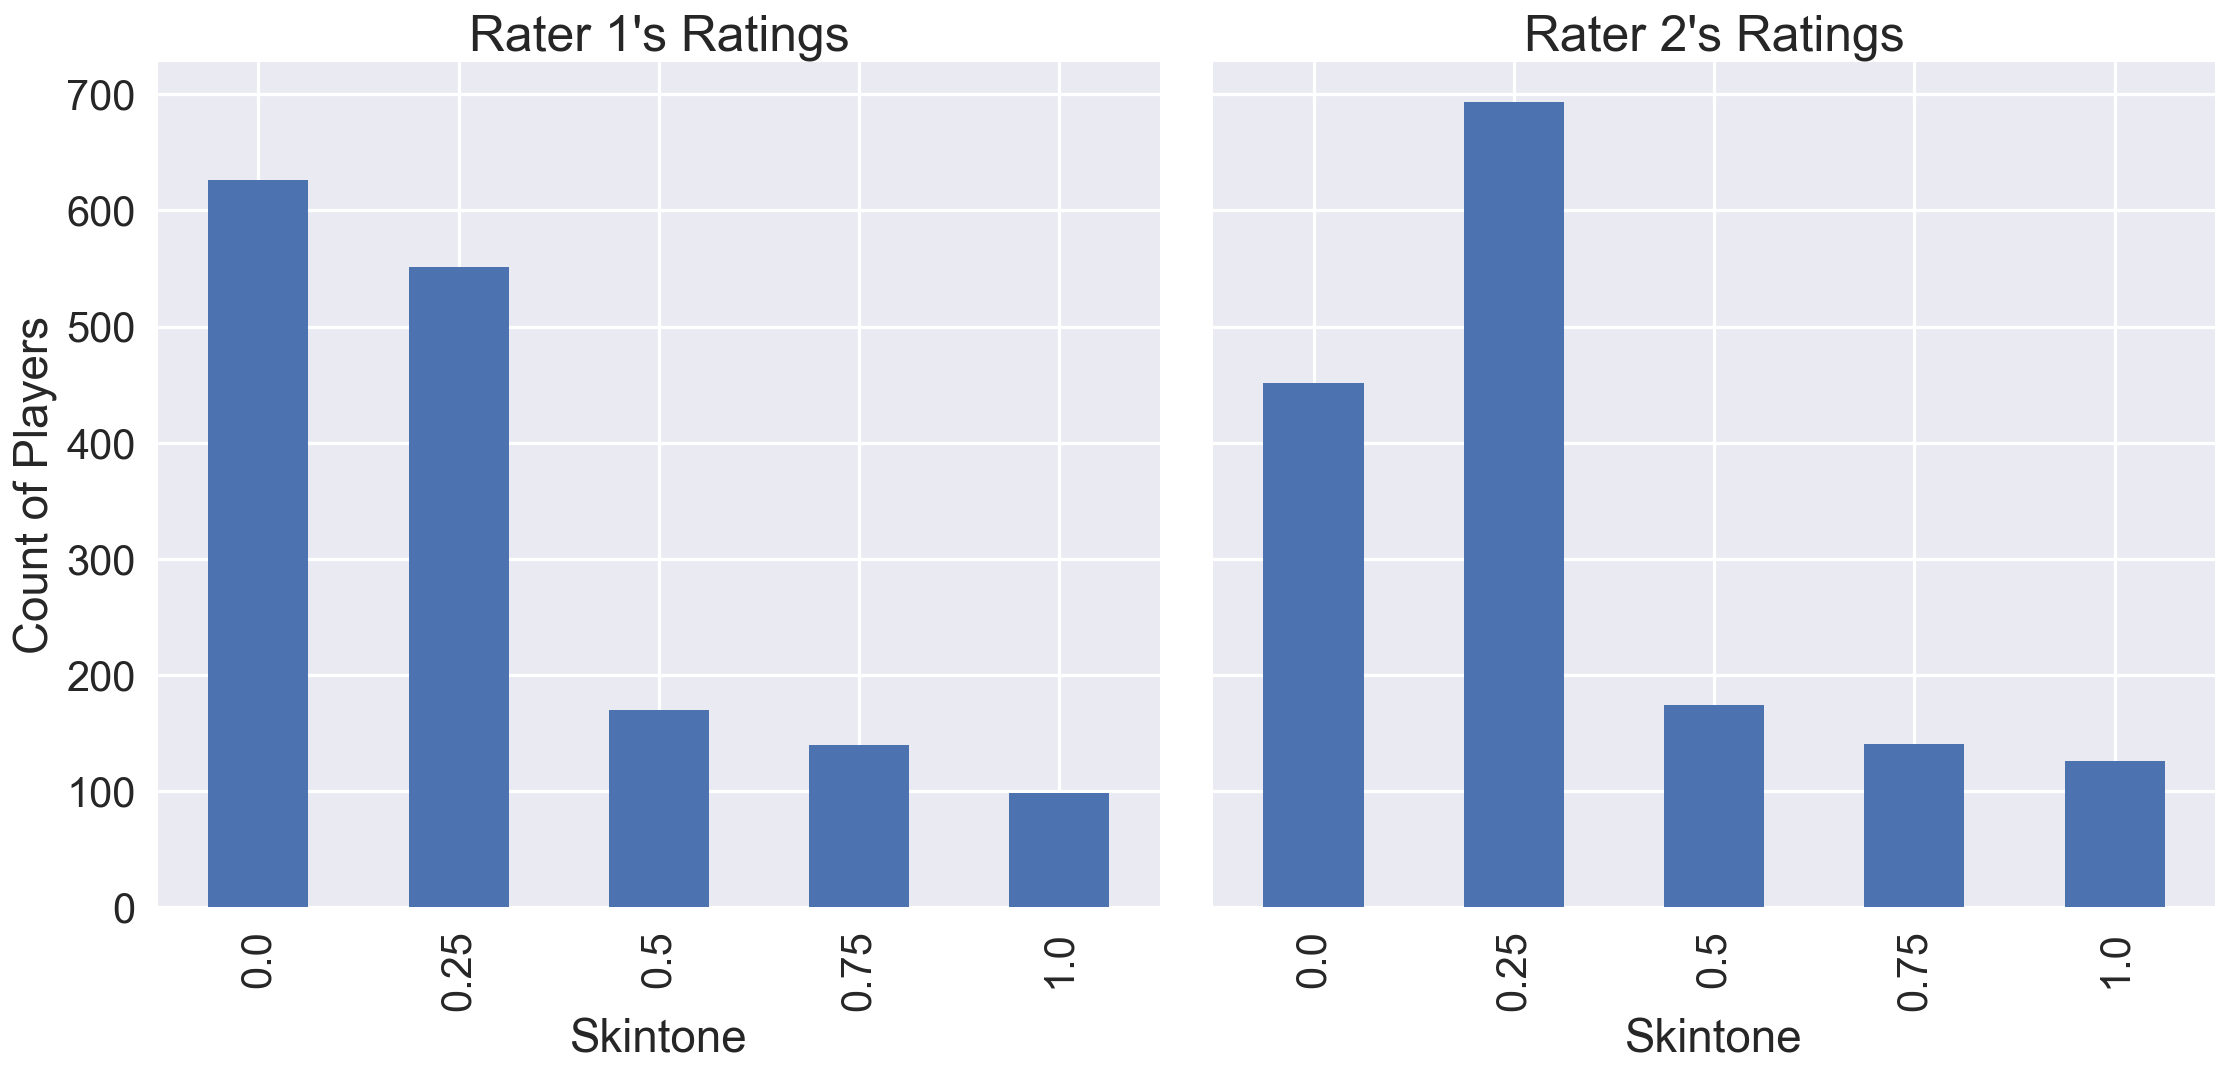

In [36]:
## visualize the distribution of skin tone among players
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True)
# rater 1
player_df.groupby('rater1')['playerShort'].count().plot(kind='bar', ax=axes[0]);
axes[0].set_xlabel("Skintone");
axes[0].set_ylabel("Count of Players");
axes[0].set_title("Rater 1's Ratings");
# rater 2
player_df.groupby('rater2')['playerShort'].count().plot(kind='bar', ax=axes[1]);
axes[1].set_xlabel("Skintone");
axes[1].set_title("Rater 2's Ratings");
fig.tight_layout();


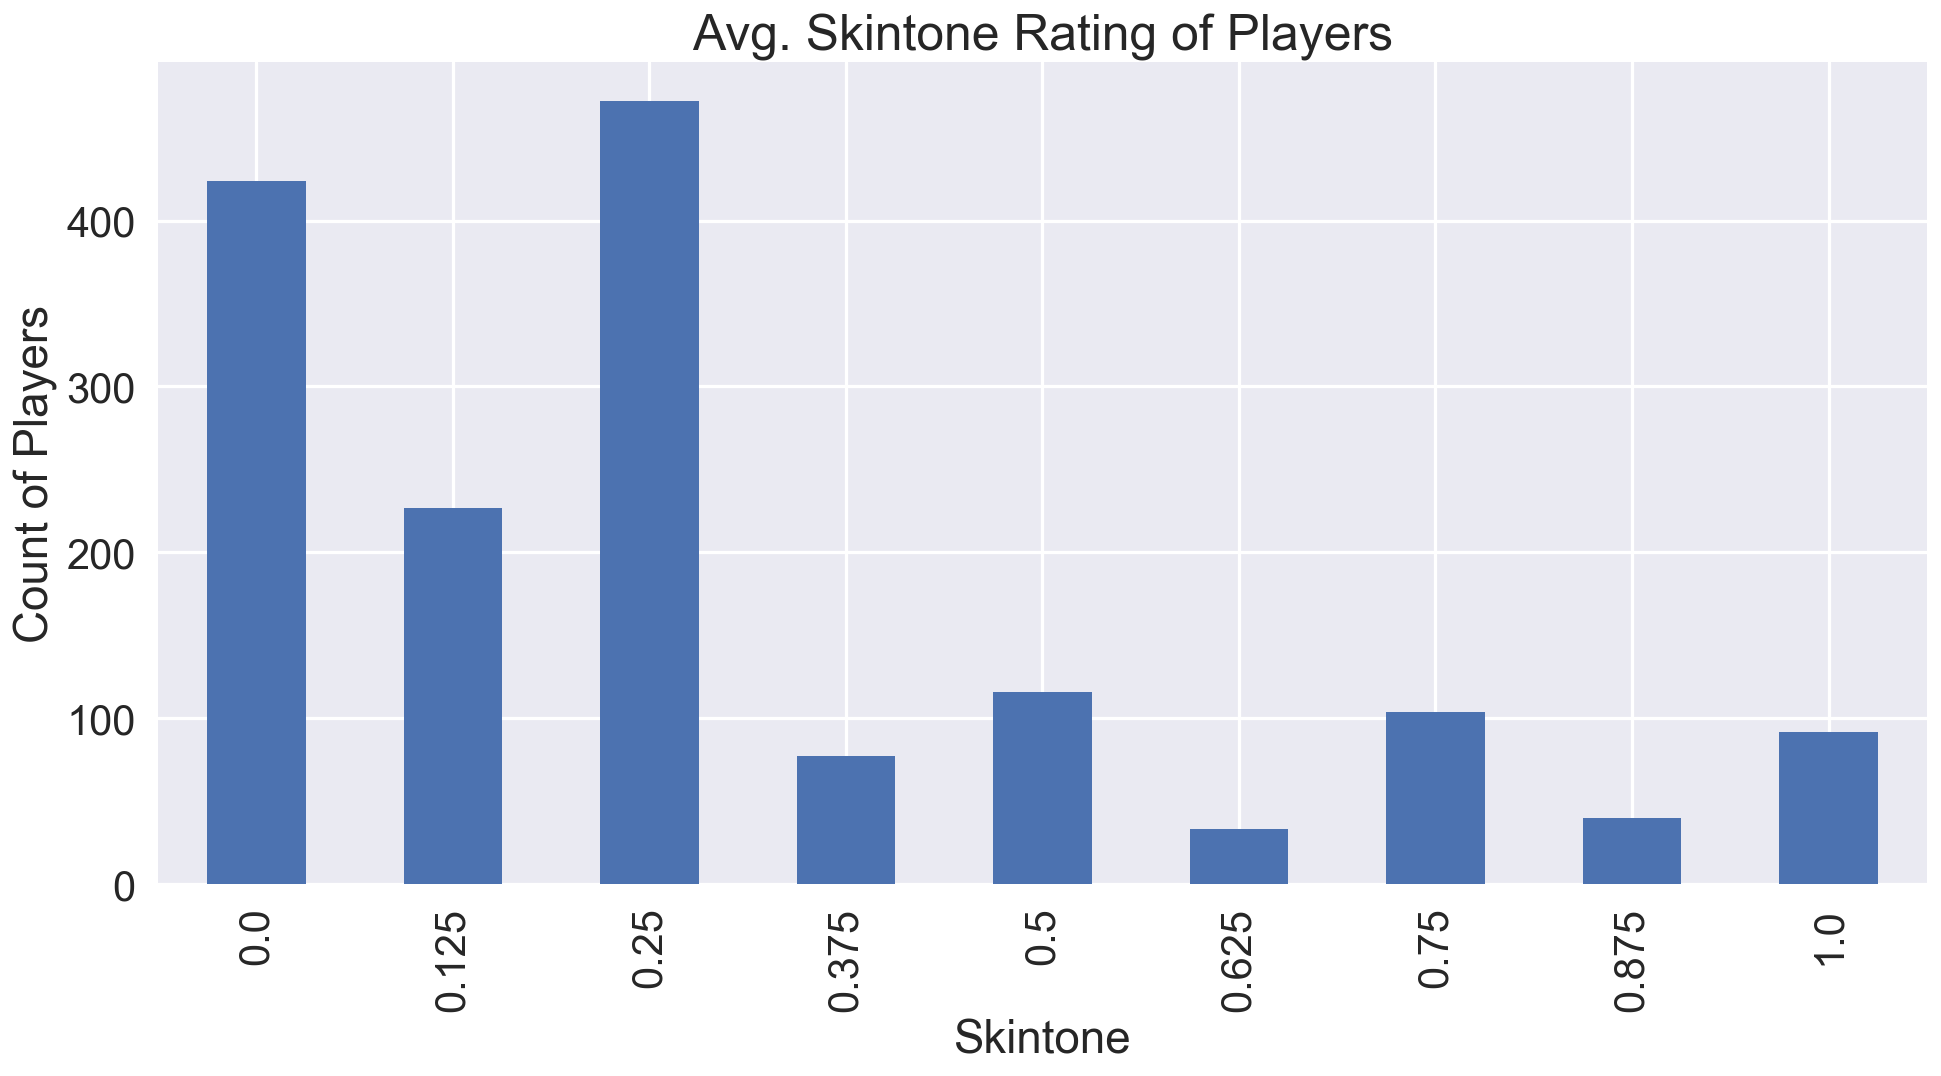

In [42]:
## visualize the average skin tone
fig, ax = plt.subplots(figsize=(14,8))
# rater 1
player_df.groupby('skintone')['playerShort'].count().plot(kind='bar', ax=ax);
ax.set_xlabel("Skintone");
ax.set_ylabel("Count of Players");
ax.set_title("Avg. Skintone Rating of Players");
fig.tight_layout()


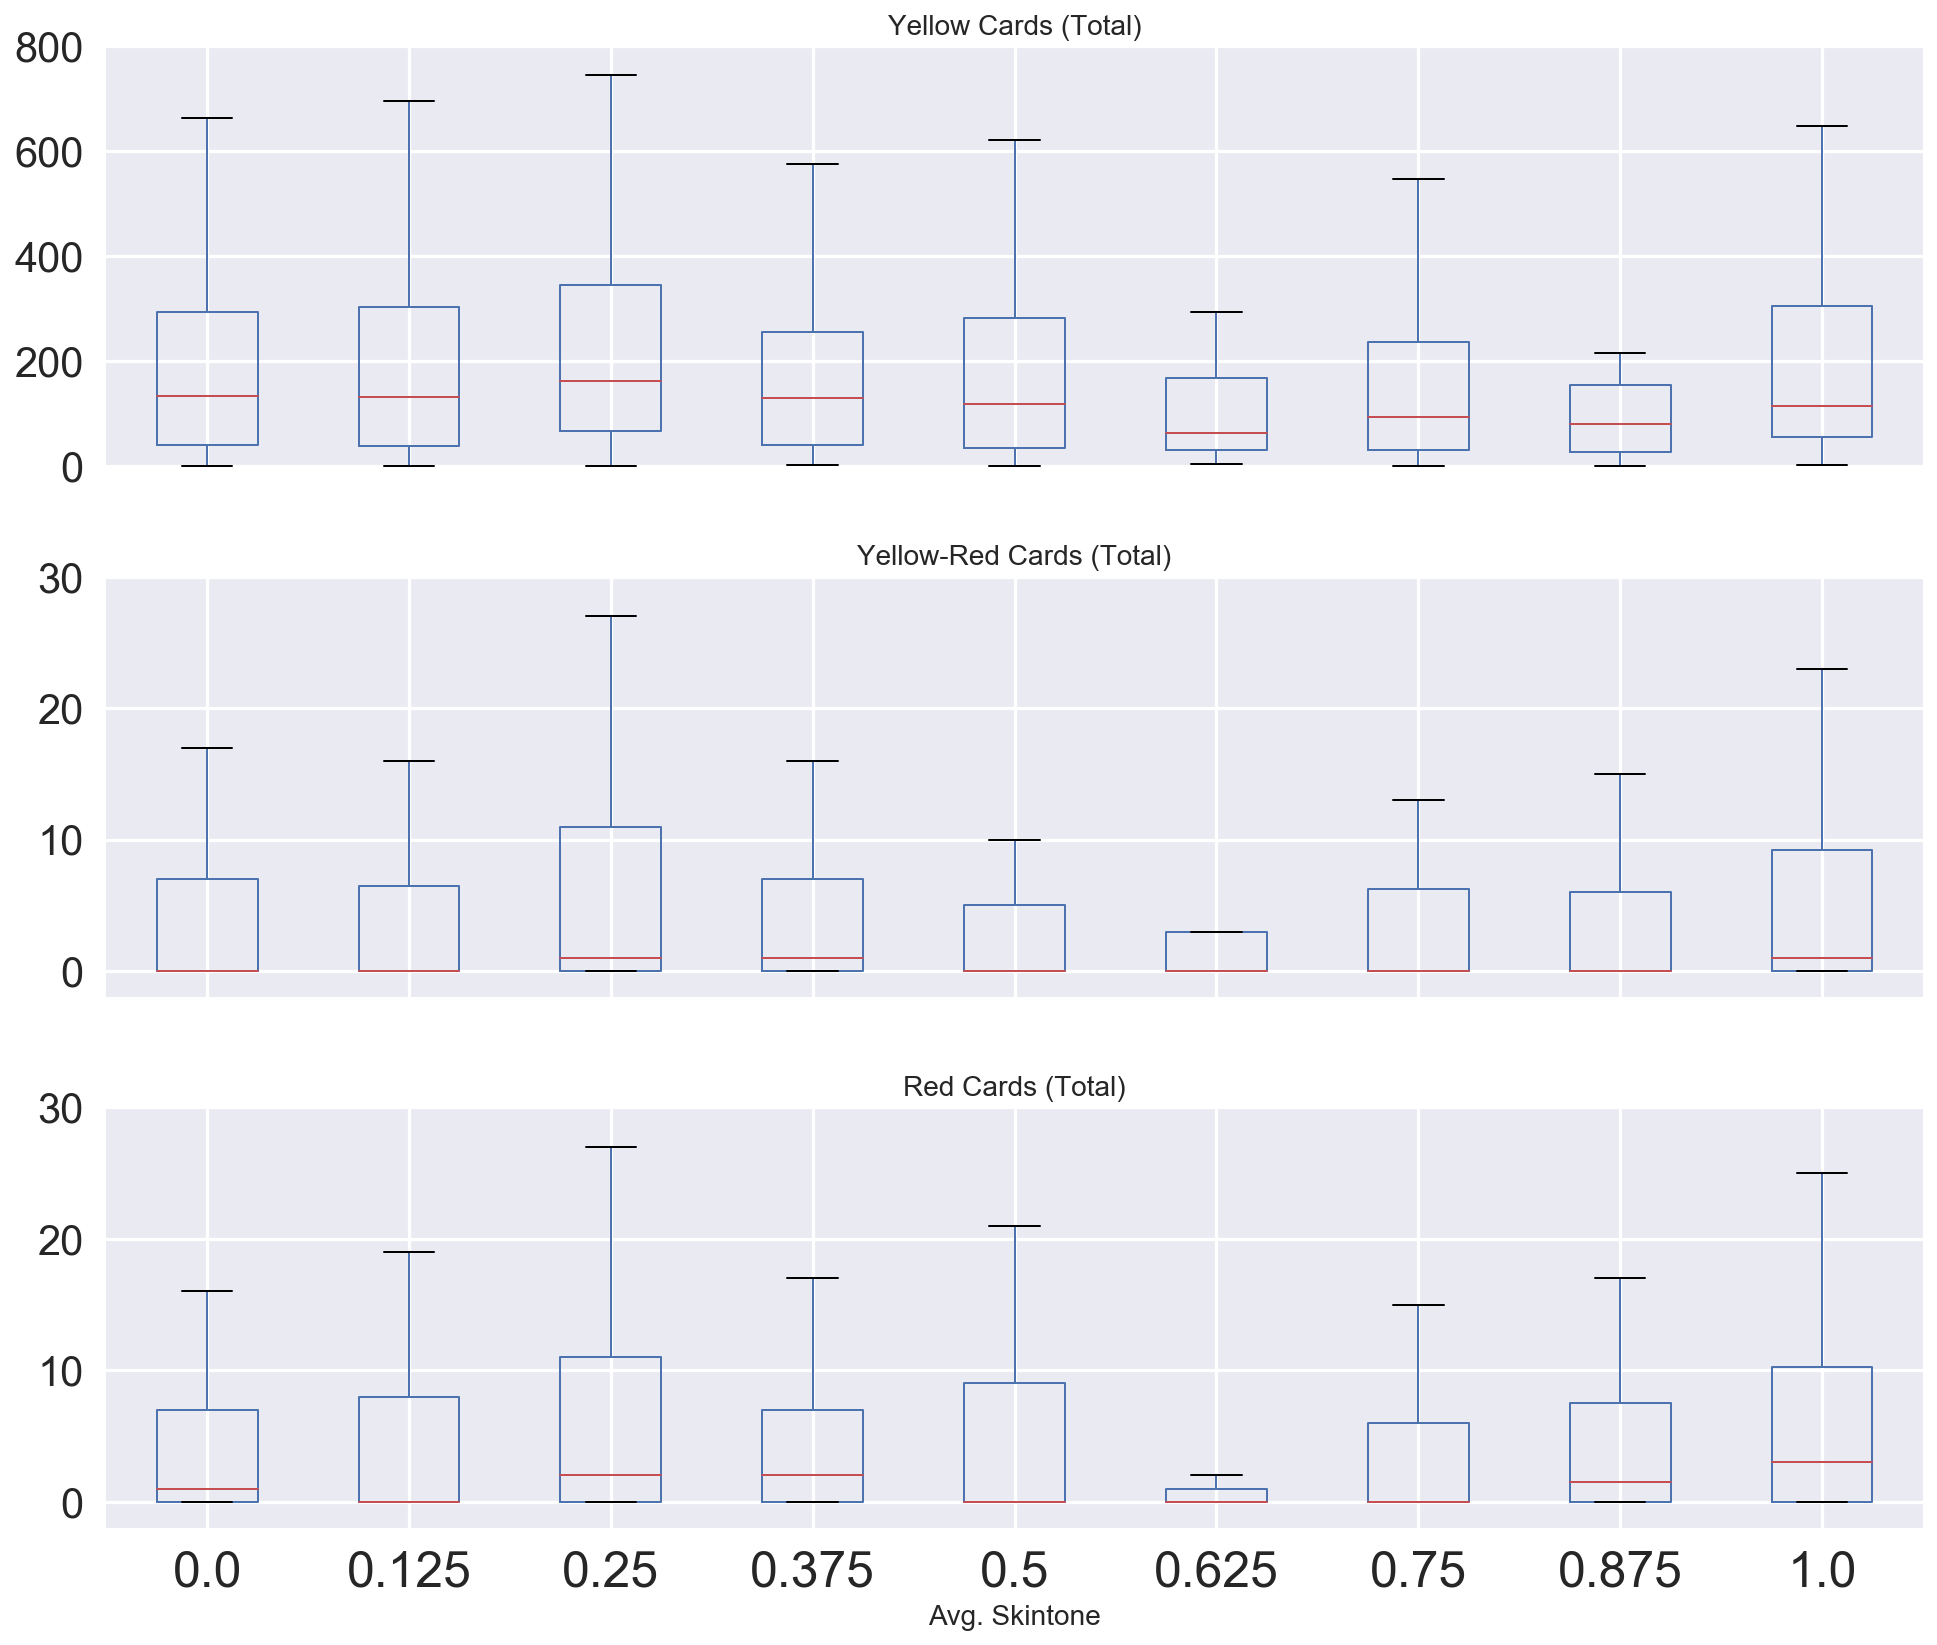

In [12]:
## how many yellow, yellowRed, and red cards are given (total) to players as a function of skintone?
g = dfd.groupby(['playerShort', 'skintone'], as_index=False)[['yellowCards', 'yellowReds', 
                                                              'redCards', 'allreds']].sum()

# visualize results
fig, axes = plt.subplots(3, 1, figsize=(14,12), sharex=True)
ax = axes[0]
g[['skintone', 'yellowCards']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-2, 800));
ax.set_title("Yellow Cards (Total)", size=14);
#ax.set_ylabel("Total Yellow Cards Received", size=14);
ax.set_xlabel("");
# visualize results
ax = axes[1]
g[['skintone', 'yellowReds']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-2, 30));
ax.set_title("Yellow-Red Cards (Total)", size=14);
#ax.set_ylabel("Total Yellow-Red Cards Received", size=14);
ax.set_xlabel("");
# visualize results
ax = axes[2]
g[['skintone', 'redCards']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-2, 30));
ax.set_title("Red Cards (Total)", size=14);
#ax.set_ylabel("Total Red Cards Received", size=14);
ax.set_xlabel("Avg. Skintone", size=14);

fig.suptitle("");
fig.tight_layout();


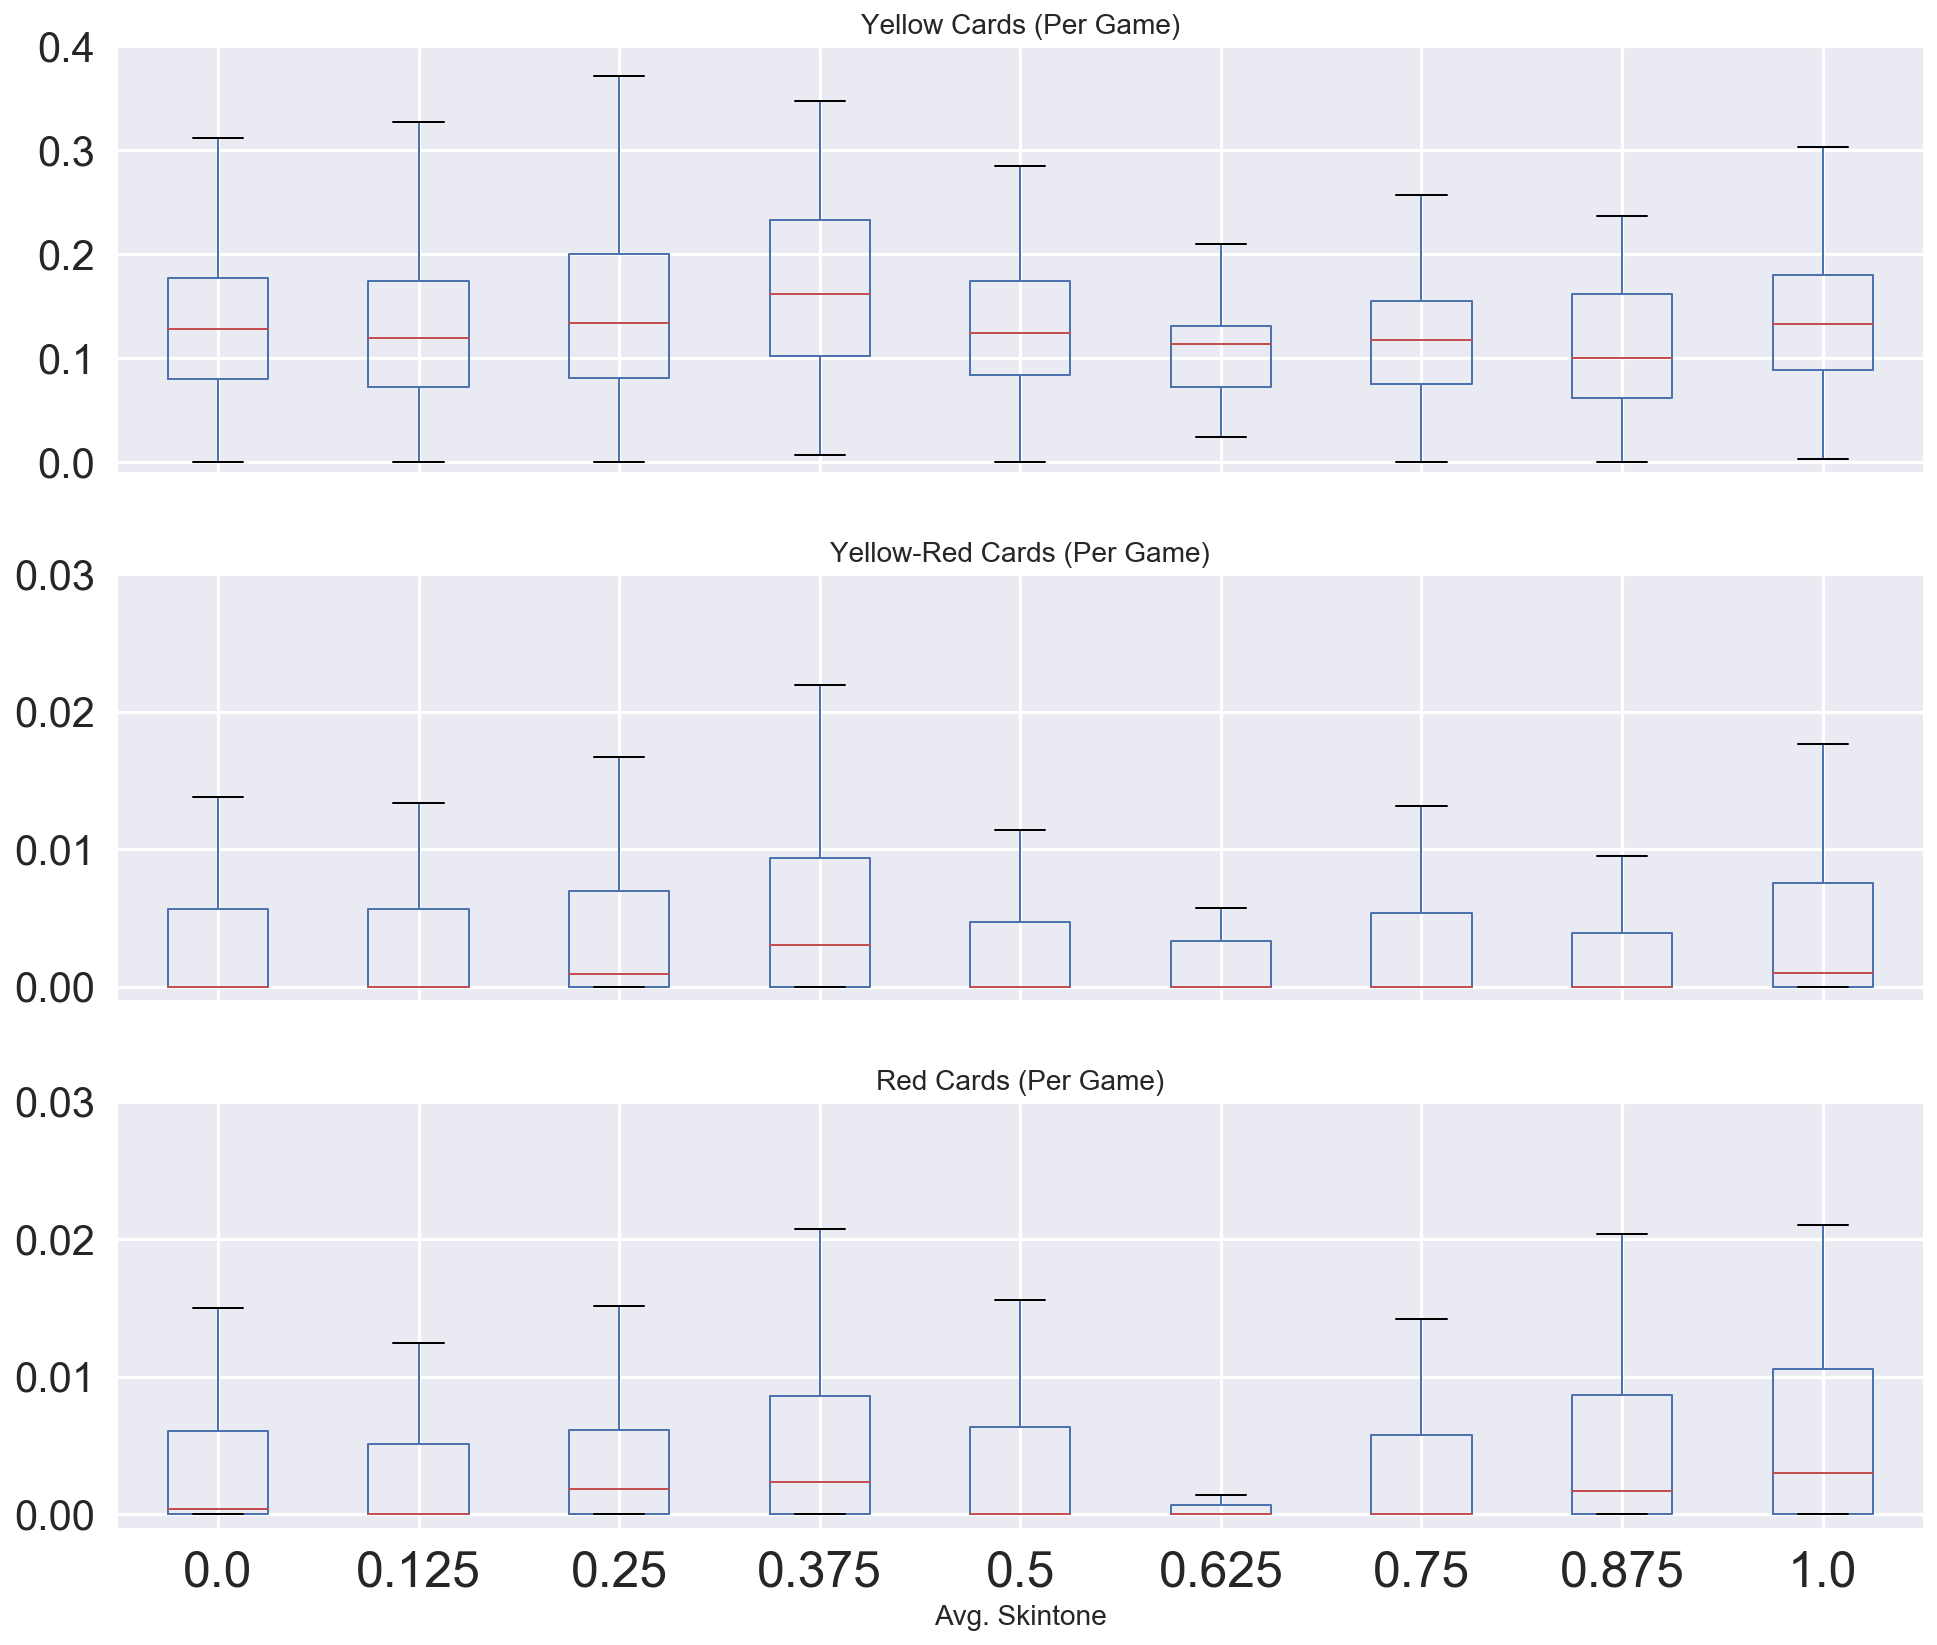

In [15]:
## what about looking at avg cards-per-game for number of games played?

# get total games by player
total_games_by_player = dfd.groupby(['playerShort'], as_index=False)['games'].sum()

# merge dataframes
games_and_cards = pd.merge(g, total_games_by_player, on='playerShort')
# divide cards by games to get cards per game
games_and_cards['yellowNorm'] = games_and_cards['yellowCards']/games_and_cards['games']
games_and_cards['yellowRedNorm'] = games_and_cards['yellowReds']/games_and_cards['games']
games_and_cards['redNorm'] = games_and_cards['redCards']/games_and_cards['games']

# visualize results
fig, axes = plt.subplots(3, 1, figsize=(14,12), sharex=True)
ax = axes[0]
games_and_cards[['skintone', 'yellowNorm']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-0.01, .4));
ax.set_title("Yellow Cards (Per Game)", size=14);
#ax.set_ylabel("Total Yellow Cards Received", size=14);
ax.set_xlabel("");
# visualize results
ax = axes[1]
games_and_cards[['skintone', 'yellowRedNorm']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-0.001, .03));
ax.set_title("Yellow-Red Cards (Per Game)", size=14);
#ax.set_ylabel("Total Yellow-Red Cards Received", size=14);
ax.set_xlabel("");
# visualize results
ax = axes[2]
games_and_cards[['skintone', 'redNorm']].boxplot(by='skintone', ax=ax);
ax.set_ylim((-0.001, .03));
ax.set_title("Red Cards (Per Game)", size=14);
#ax.set_ylabel("Total Red Cards Received", size=14);
ax.set_xlabel("Avg. Skintone", size=14);

fig.suptitle("");
fig.tight_layout();


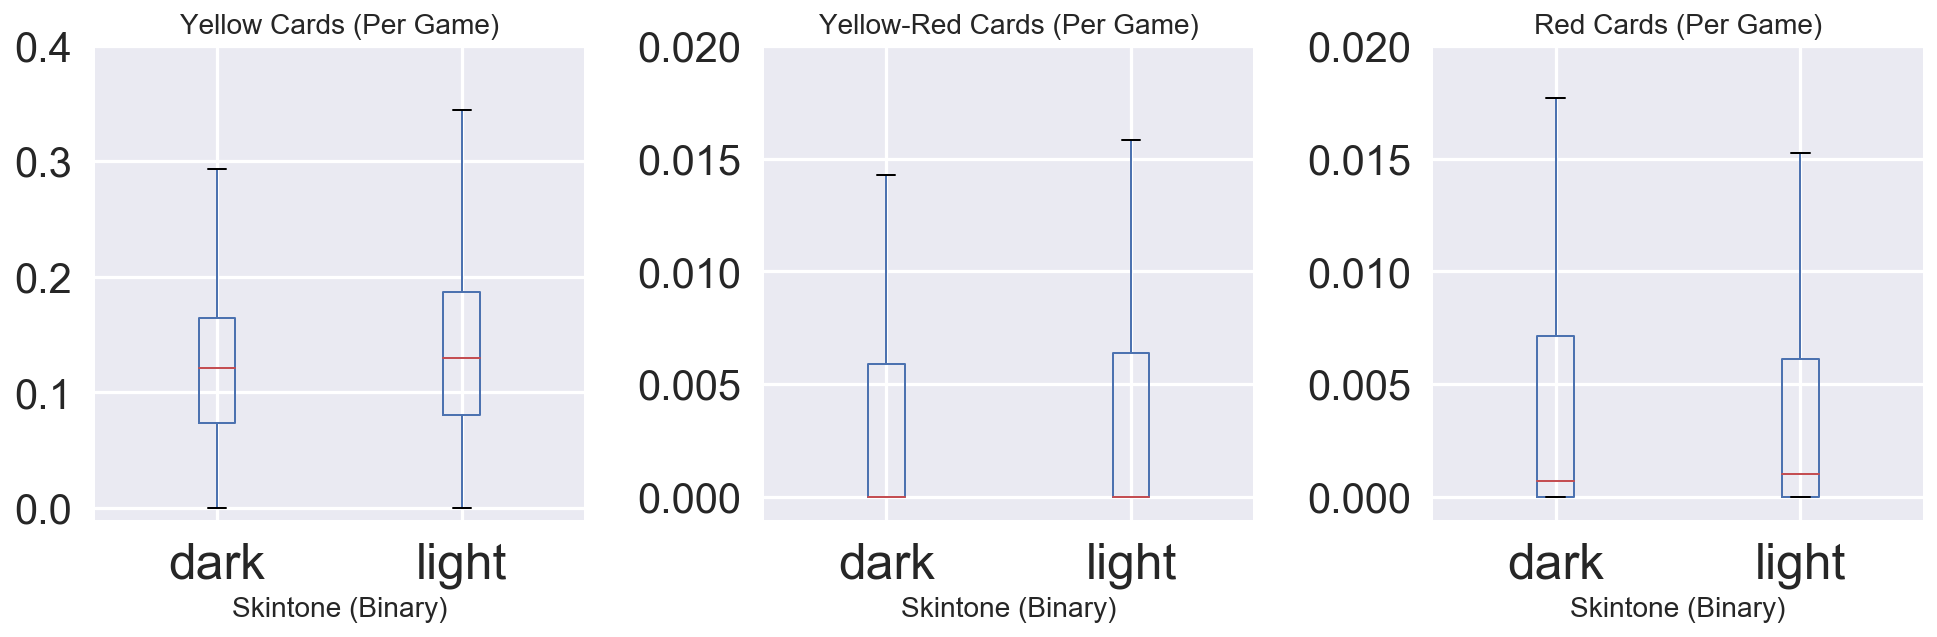

In [33]:
## if we divide players into light (skintone < 0.5) and dark (skintone > 0.5), what do we see?

def binary_skintone(s):
    if s < 0.5:
        return 'light'
    elif s > 0.5:
        return 'dark'
    else: # skintone == 0.5
        return None
    
# assign binary skintone labels to players
games_and_cards['skintone_binary'] = games_and_cards['skintone'].apply(binary_skintone)
# make same figures as above, but only using binary labels
bin_only_df = games_and_cards.dropna(subset=['skintone_binary'])

# visualize results
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharex=True)
ax = axes[0]
bin_only_df[['skintone_binary', 'yellowNorm']].boxplot(by='skintone_binary', ax=ax);
ax.set_ylim((-0.01, .4));
ax.set_title("Yellow Cards (Per Game)", size=14);
#ax.set_ylabel("Total Yellow Cards Received", size=14);
ax.set_xlabel("Skintone (Binary)", size=14);

# visualize results
ax = axes[1]
bin_only_df[['skintone_binary', 'yellowRedNorm']].boxplot(by='skintone_binary', ax=ax);
ax.set_ylim((-0.001, .02));
ax.set_title("Yellow-Red Cards (Per Game)", size=14);
#ax.set_ylabel("Total Yellow-Red Cards Received", size=14);
ax.set_xlabel("Skintone (Binary)", size=14);

# visualize results
ax = axes[2]
bin_only_df[['skintone_binary', 'redNorm']].boxplot(by='skintone_binary', ax=ax);
ax.set_ylim((-0.001, .02));
ax.set_title("Red Cards (Per Game)", size=14);
#ax.set_ylabel("Total Red Cards Received", size=14);
ax.set_xlabel("Skintone (Binary)", size=14);

fig.suptitle("");
fig.tight_layout();
